<center><img src="Logolink_OP_VVV_hor_barva_cz.jpg" width="600px"/></center>

#### <center>ESF projekt Západočeské univerzity v Plzni reg. č. CZ.02.2.69/0.0/0.0/16 015/0002287</center>

# KKY/USVP 4 Segmentation

In [ ]:
%pylab inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import data
from skimage.color import rgba2rgb,rgb2gray
import skimage.segmentation
import scipy
import skimage.io

## Thresholding

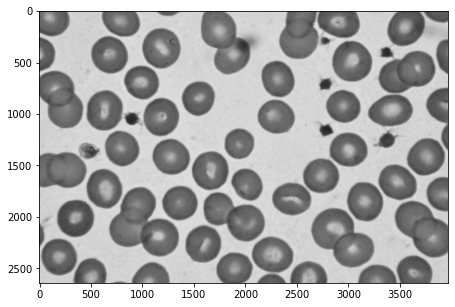

In [183]:
# Taken from: https://pixnio.com/science/microscopy-images/malaria-plasmodium/micrograph-depicts-a-mature-plasmodium-vivax-trophozoite
# Licence: https://creativecommons.org/licenses/publicdomain/
im = skimage.io.imread("cviceni_4/cells.jpg")

plt.figure(figsize=(10,5))
plt.imshow(im[:,:,0], cmap="gray") # colormap grayscale
plt.show() # nothing showed without this line

In [ ]:
imgr = im[:,:,0]


In [ ]:
# Function computing histogram of the image (fixed for 256 bins)
def histogram(image):
    hist = np.zeros(256, dtype=int)
    for i in image.ravel():
        hist[i] += 1
    return hist

h = histogram(imgr)
# Show histogram
plt.figure(figsize=(10,10))
plt.plot(h)
plt.show()

In [ ]:
imb = imgr < 110

plt.figure(figsize=(10,5))
plt.imshow(imb, cmap="gray") # colormap grayscale
plt.show() # nothing showed without this line

In [ ]:
imb2 = imgr.copy()
imb2[(imgr < 65)] = 255
imb2[(65 <= imgr) == (imgr < 110)] = 200
imb2[(110 <= imgr) == (imgr < 160)] = 100
imb2[160 <= imgr] = 0

plt.figure(figsize=(10,5))
plt.imshow(imb2, cmap="gray") # colormap grayscale
plt.show() # nothing showed without this line

## Edge Detection

In [ ]:
im = skimage.io.imread("cviceni_4/lego1.png")
imgr = rgb2gray(rgba2rgb(im, (0.4,0.4,0.4)))

plt.figure(figsize=(10,5))
plt.imshow(imgr, cmap="gray") # colormap grayscale
plt.show() # nothing showed without this line

print(im.shape)

In [ ]:
def edge_detect(img, mask):
    """
        Function edge_detect

        Function applies mask in order to detect edges in the image. 

        @param img input image
        @param mask input mask of size == 3 + 2*k , k = 0,1,2,...  

    """
    if (mask.shape[0] != mask.shape[1]):
        return None
    if (mask.shape[0] % 2) == 0:
        return None
    if (mask.shape[0] == 1):
        return None
    h = (mask.shape[0] // 2)
    output = np.zeros([img.shape[0]-(2*h), img.shape[1]-(2*h)])
    for y in range(h, img.shape[0] - h):
        for x in range(h, img.shape[1] - h):
            output[y - h, x -h] = np.sum(img[y-h:y+h+1,x-h:x+h+1] * mask)
    return output

In [ ]:
# Mask generation
mask = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

output = edge_detect(imgr, mask)

plt.imshow(output, cmap="gray") # colormap grayscale
plt.show()


In [ ]:
output3 = skimage.img_as_ubyte(output)

In [ ]:
plt.imshow(output3, cmap="gray") # colormap grayscale
plt.show()

print(np.max(output3))

In [ ]:
plt.imshow(output3 > 25, cmap="gray") # colormap grayscale
plt.show()


In [ ]:
# Mask generation
mask2 = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])

output2 = edge_detect(imgr, mask2)

In [ ]:
output3 = skimage.img_as_ubyte(output2)
plt.imshow(output3, cmap="gray") # colormap grayscale
plt.show()

print(np.max(output3))

In [ ]:
plt.imshow(output3 > 25, cmap="gray") # colormap grayscale
plt.show()

In [ ]:
mask3 = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
mask4 = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

output3 = edge_detect(imgr, mask3)
output4 = edge_detect(imgr, mask4)

In [ ]:
output_int = skimage.img_as_ubyte(output)
output2_int = skimage.img_as_ubyte(output2)
output3_int = skimage.img_as_ubyte(output3)
output4_int = skimage.img_as_ubyte(output4)

output5 = (output_int > 25) + (output2_int > 25) + (output3_int > 25) + (output4_int > 25)

plt.imshow(output5, cmap="gray") # colormap grayscale
plt.show()

In [ ]:
from skimage.feature import canny
edges = canny(imgr, low_threshold=0, high_threshold=0.05)

plt.imshow(edges, cmap="gray") # colormap grayscale
plt.show()

## Region Growing

In [ ]:
def homogenity(image, limit):
    if (np.max(image) - np.min(image)) <= limit:
        return True
    else:
        return False

def neighbours(r1,r2):
    if min(abs(r1[0] - r2[2]), abs(r1[1] - r2[3]) , abs(r1[2] - r2[0]) , abs(r1[3] - r2[1])) <= 1:
        return True
    else:
        return False

def region_growing(image, limit, min_size=4):
    # SPLITING
    todo_regions = []
    done_regions = []

    todo_regions.append([0,0,image.shape[0],image.shape[1]])
    while True:
        if len(todo_regions) > 0:
            cr = todo_regions.pop(0)
            if homogenity(image[cr[0]:cr[2], cr[1]:cr[3]], limit):
                done_regions.append(cr)
            else:
                if ((cr[2]-cr[0]) * (cr[3]-cr[1])) < min_size:
                    done_regions.append(cr)
                    continue
                todo_regions.append([cr[0], cr[1],cr[0] + (cr[2]-cr[0])//2, cr[1] +(cr[3]-cr[1])//2])
                todo_regions.append([cr[0]+((cr[2]-cr[0])//2), cr[1],cr[2], cr[1] + (cr[3]-cr[1])//2])
                todo_regions.append([cr[0], cr[1]+((cr[3]-cr[1])//2),cr[0] +(cr[2]-cr[0])//2, cr[3]])
                todo_regions.append([cr[0]+((cr[2]-cr[0])//2), cr[1]+((cr[3]-cr[1])//2),cr[2], cr[3]]) 
        else:
            break

    regions = [-1]*len(done_regions)
    regions[0] = 0
    region_number = 0    
    for i, cr in enumerate(done_regions):
        reg_max = 0
        reg_min = 255

        for i2, cr2 in enumerate(done_regions): 
            if regions[i] == regions[i2]:
                reg_max = max(reg_max, np.max(image[cr2[0]:cr2[2], cr2[1]:cr2[3]]))
                reg_min = min(reg_min, np.min(image[cr2[0]:cr2[2], cr2[1]:cr2[3]]))                
 
        if regions[i] == -1:
            region_number += 1
            regions[i] = region_number
        for i2, cr2 in enumerate(done_regions): 
            if i2 <= i:
                continue
            if regions[i] == regions[i2]:
                continue
            else:
                if neighbours(cr, cr2):
                    min_value = min(reg_min, np.min(image[cr2[0]:cr2[2], cr2[1]:cr2[3]]))
                    max_value = max(reg_max, np.max(image[cr2[0]:cr2[2], cr2[1]:cr2[3]]))
                    if (max_value - min_value) <= limit:
                        if regions[i2] == -1:
                            regions[i2] = regions[i]
                        else:
                            regions[regions == regions[i2]] = regions[i]                            

    return regions, done_regions


In [ ]:
im = skimage.io.imread("cviceni_4/road.jpg")
imgr = skimage.img_as_ubyte(rgb2gray(im))

plt.figure(figsize=(10,5))
plt.imshow(imgr, cmap="gray") # colormap grayscale
plt.show() # nothing showed without this line

print(imgr.shape, type(imgr[0,0]))

In [ ]:
indices, regions = region_growing(imgr, 100)

In [ ]:
imgr2 = imgr.copy()

for i in range(0, max(indices)):
    ith_region = []
    for index, value in enumerate(indices):
        if i == value:
            cr = regions[index]
            ith_region = np.concatenate((ith_region, list(imgr[cr[0]:cr[2], cr[1]:cr[3]].ravel())))
    mean = np.mean(ith_region)
    for index, value in enumerate(indices):
        if i == value:
            cr = regions[index]
            imgr2[cr[0]:cr[2], cr[1]:cr[3]] = np.uint8(mean)



In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(imgr2, cmap="gray") # colormap grayscale
plt.show() # noth

In [ ]:
print(max(indices), len(regions))

In [ ]:
indices2, regions2 = region_growing(imgr2, 100)

In [ ]:
imgr3 = imgr2.copy()

for i in range(0, max(indices)):
    ith_region = []
    for index, value in enumerate(indices):
        if i == value:
            cr = regions[index]
            ith_region = np.concatenate((ith_region, list(imgr2[cr[0]:cr[2], cr[1]:cr[3]].ravel())))
    mean = np.mean(ith_region)
    for index, value in enumerate(indices):
        if i == value:
            cr = regions[index]
            imgr3[cr[0]:cr[2], cr[1]:cr[3]] = np.uint8(mean)


In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(imgr3, cmap="gray") # colormap grayscale
plt.show() # noth